# Configuration

## Modules

In [87]:
import pandas as pd
import seaborn as sb
import nltk
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora
from gensim.models import CoherenceModel 
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')


!pip install pyLDAvis
import pyLDAvis
from pyLDAvis import gensim_models


import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Constants

In [88]:
INPUT_FILE = '/content/drive/MyDrive/MA5851_A3/scrape_results.csv'
TEXT_COLUMN ="Bag Of Words"
STOP_WORDS = set(stopwords.words('english'))
EXCLUDE_CHARACTERS = set(string.punctuation)
TOKENIZER_FUNCTION = WordNetLemmatizer().lemmatize
NUM_TOPICS=12
PASSES=50
MINIMUM_PROBABILITY=0.0
#Set bigram, trigram, etc
GRAM_N = 1
DELIMITER = b' '
NUM_TOPICS = [3,5,7]
ALPHA = 0.1

## Functions

In [89]:
def Clean(doc, tokenizer, exclude, stop):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(tokenizer(word) for word in punc_free.split())
    return normalized

In [90]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))  # deacc = True removes punctuations

In [91]:
def Make_Ngrams(texts, gram_mod):
    return [gram_mod[doc] for doc in texts]

In [92]:
def Get_Tuple_Value(tup: tuple, x: int):
  return tup[x]

In [93]:
def Filter_By_P_Value(coef, p_values, alpha):
      output = coef.copy(deep =True)
      for column in p_values:
        for i, j in p_values[column].items():
            if j > alpha:
              output.loc[i, column] = float("NaN")
      return output

def Add_P_Value_Markers(coef, p_values, alpha, character):
      output = coef.copy(deep =True)
      for column in p_values:
        for i, j in p_values[column].items():
            if j < alpha:
              output.loc[i, column] = str(coef.loc[i, column].round(decimals = 6)) + character
            else:
                output.loc[i, column] = coef.loc[i, column]
      return output

def Pearsonr_Pval(x,y):
        return stats.pearsonr(x,y)[1]

# Execute

## Topic Modelling

In [94]:
data = pd.read_csv(INPUT_FILE)
len(data)

144

In [95]:
%%capture
#Select list of documents from data 
doc_complete = data[TEXT_COLUMN]
# String cleaning
doc_clean = [Clean(doc, tokenizer=TOKENIZER_FUNCTION,exclude=EXCLUDE_CHARACTERS,stop=STOP_WORDS).split() for doc in doc_complete]

#Make Ngrams
words = sent_to_words(doc_clean)
gram_mod = gensim.models.Phrases(words, min_count=GRAM_N, delimiter=DELIMITER)
ngrams = Make_Ngrams(doc_clean, gram_mod)

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(ngrams)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in ngrams]

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

corpus = [dictionary.doc2bow(text) for text in ngrams]


In [96]:
%%capture
max_coherence = 0
optimal_n_topics = 0
perplexity_scores = []
coherence_scores = []
for n in NUM_TOPICS:
  ldamodel = Lda(doc_term_matrix, num_topics=n, id2word = dictionary, passes=PASSES, minimum_probability=MINIMUM_PROBABILITY)
  perplexity = ldamodel.log_perplexity(corpus)
  coherence = CoherenceModel(model=ldamodel, texts=ngrams, dictionary=dictionary, coherence='c_v').get_coherence()
  perplexity_scores.append(perplexity)
  coherence_scores.append(coherence)
  if coherence > max_coherence:
    max_coherences = coherence
    optimal_n_topics = n
ldamodel = Lda(doc_term_matrix, num_topics=optimal_n_topics, id2word = dictionary, passes=PASSES, minimum_probability=MINIMUM_PROBABILITY)

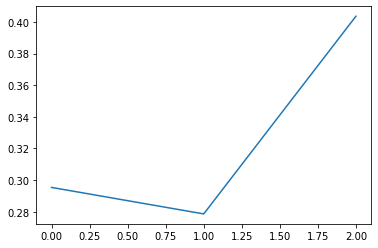

In [97]:
plt.plot(coherence_scores)

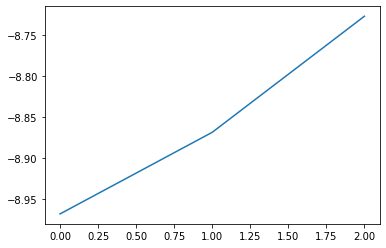

In [98]:
plt.plot(perplexity_scores)

In [99]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.268362  0.048700       1        1  40.528760
2     -0.050572 -0.128097       2        1  18.715445
5     -0.059561  0.159228       3        1  11.897180
0     -0.124065  0.098390       4        1  11.000882
6     -0.018580 -0.110284       5        1   8.534504
3      0.021037 -0.041517       6        1   7.795237
4     -0.036622 -0.026419       7        1   1.527992, topic_info=                    Term        Freq        Total Category  logprob  loglift
239                 span  850.000000   850.000000  Default  30.0000  30.0000
883               police  745.000000   745.000000  Default  29.0000  29.0000
269                 time  865.000000   865.000000  Default  28.0000  28.0000
3913                   n  156.000000   156.000000  Default  27.0000  27.0000
16                     a  658.000000   658.000000  Default  26.0000  26.0000
...                  ...         ...          ...      ...      ...      ...
4127                  17    2.879729    34.785115   Topic7  -6.6948   1.6897
167                 made    3.093657   100.471502   Topic7  -6.6231   0.7007
1315               court    3.093664   114.344957   Topic7  -6.6231   0.5714
996   span stylefontsize    3.093674   195.853594   Topic7  -6.6231   0.0332
219                 said    3.332857  1538.146441   Topic7  -6.5487  -1.9533

[488 rows x 6 columns], token_table=      Topic      Freq Term
term                      
488       1  0.272849   12
488       2  0.240108   12
488       3  0.141882   12
488       4  0.065484   12
488       5  0.251022   12
...     ...       ...  ...
1095      5  0.088415    –
1095      6  0.092836    –
1095      7  0.008842    –
8316      2  0.149784   ‘i
8316      5  0.823812   ‘i

[888 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 6, 1, 7, 4, 5])

In [100]:
topics = pd.DataFrame(ldamodel[corpus])
topics = topics.applymap(lambda x: Get_Tuple_Value(x,1))

In [101]:
topics.columns= pd.DataFrame(ldamodel.print_topics(num_topics = optimal_n_topics, num_words = 3))[1]

## Sentiment Analysis

In [102]:
vader = SentimentIntensityAnalyzer()
sentiment_scores = []
for doc in doc_complete:
  sentiment_scores.append(vader.polarity_scores(doc))

In [103]:
sentiments = pd.DataFrame(sentiment_scores)

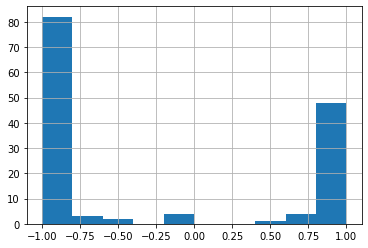

In [104]:
sentiments['compound'].hist()

## Regression Analysis

In [105]:
regression_analysis_data = pd.concat([topics,sentiments], axis = 1)
len(regression_analysis_data)

144

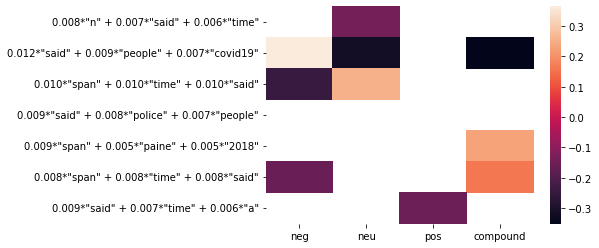

In [106]:
sentiment_variables = ["neg","neu","pos","compound"]
corr = regression_analysis_data.corr()
p_values = regression_analysis_data.corr(method = Pearsonr_Pval)
vis_data = Filter_By_P_Value(corr,p_values,ALPHA)
sb.heatmap(vis_data.loc[:,sentiment_variables].drop(sentiment_variables, axis = 0))